# **Collect Financial Data, Create a Self-updating Stock Database**
This code collects and stores data from Yahoo Finance (stock prices), Finviz (news headlines), and investing.com (macroeconomic indicators) into an SQLite database, matching your dataset description for predicting QQQ log returns from January 2017 to April 2025.

reference: 
- https://sqlite.org/index.html
- https://app.eraser.io/workspace/npJcAWKlqyuXJFB66W6J

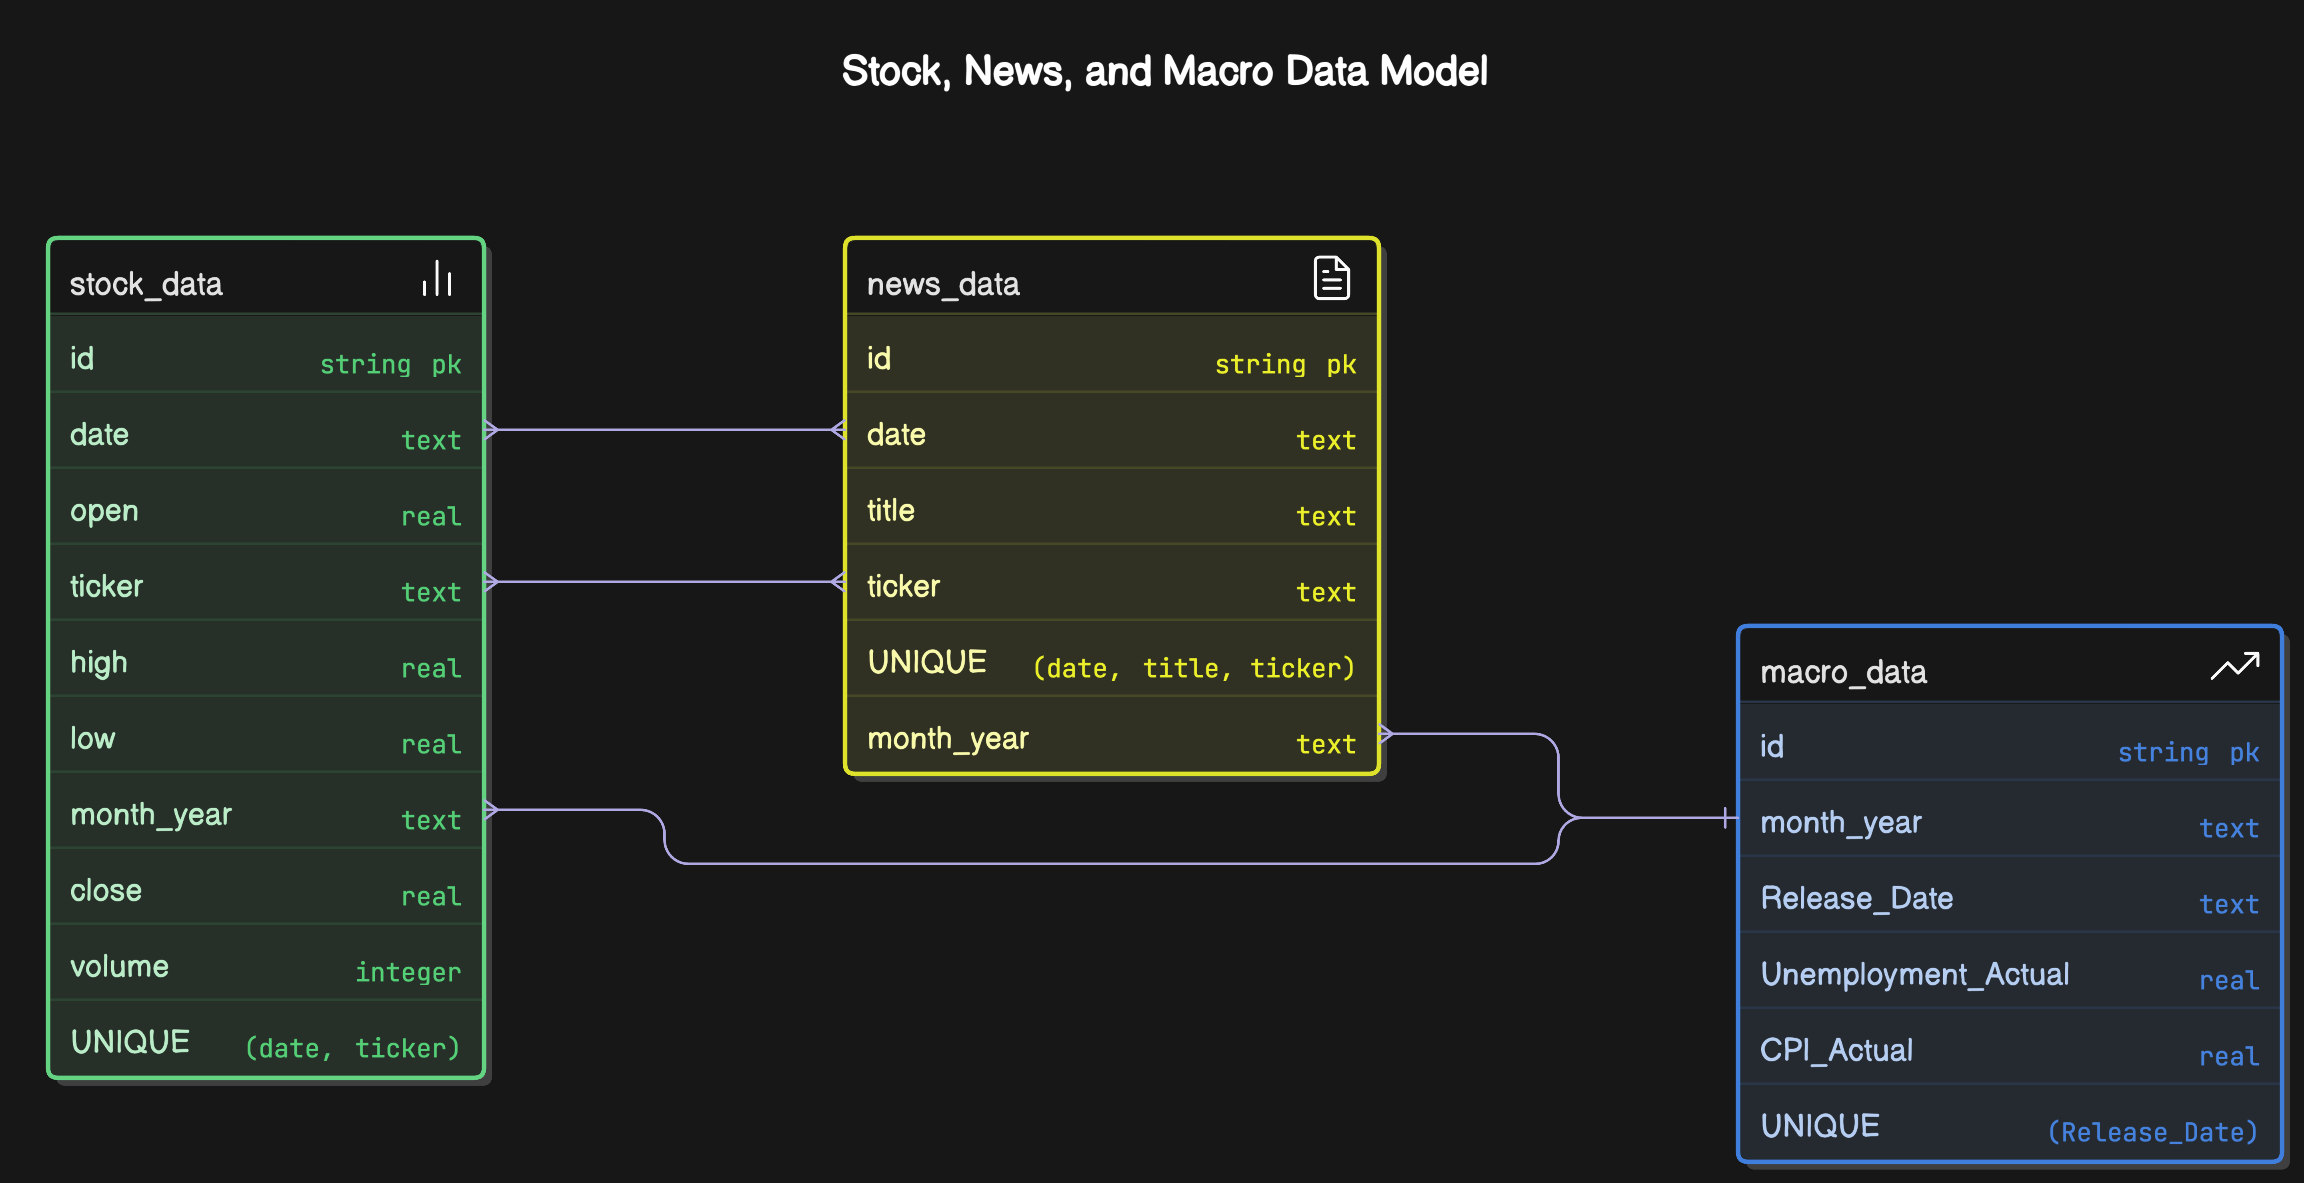

# Import Libraries
This section imports all necessary libraries for data fetching, processing, and storage.

In [1]:
import yfinance as yf              # For fetching stock price data from Yahoo Finance
import pandas as pd                # For data manipulation and DataFrame operations
import sqlite3                     # For creating and managing the SQLite database
import schedule                    # For scheduling periodic tasks (optional feature)
import time                        # For handling timing in scheduled tasks
import requests                    # For making HTTP requests to scrape web data
from bs4 import BeautifulSoup as soup  # For parsing HTML content from web pages
from urllib.request import urlopen, Request  # For opening URLs with custom headers
import datetime                    # For date and time operations
from io import StringIO            # For parsing HTML tables into DataFrames
import numpy as np                 # For numerical operations and handling NaN values
import zipfile                     # Unused in this code but included for potential future use

# Database Connection
Establishes a connection to the SQLite database where all data will be stored.

In [2]:
conn = sqlite3.connect('stock_price.sqlite')  # Creates 'stock_price.sqlite' 

# Table Creation Functions
These functions set up the database tables with unique constraints to prevent duplicates.

In [3]:
def create_stock_table(conn):
    """Create the stock_data table to store daily stock prices."""
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS stock_data (
            date TEXT,              -- Date of the stock data (e.g., '2023-10-15')
            open REAL,              -- Opening price
            high REAL,              -- Highest price of the day
            low REAL,               -- Lowest price of the day
            close REAL,             -- Closing price
            volume INTEGER,         -- Trading volume
            ticker TEXT,            -- Stock ticker (e.g., 'QQQ')
            month_year TEXT,        -- Month-year for alignment (e.g., '2023-10')
            UNIQUE (date, ticker)   -- Ensures no duplicate entries for the same date and ticker
        )
    ''')
    conn.commit()

In [4]:
def create_news_table(conn):
    """Create the news_data table to store news headlines."""
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS news_data (
            date TEXT,              -- Date of the news article
            title TEXT,             -- News headline
            month_year TEXT,        -- Month-year for alignment with other data
            ticker TEXT,            -- Associated ticker (e.g., 'QQQ')
            UNIQUE (date, title, ticker)  -- Prevents duplicate news entries
        )
    ''')
    conn.commit()

In [5]:
def create_macro_table(conn):
    """Create the macro_data table to store macroeconomic indicators."""
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS macro_data (
            month_year TEXT,        -- Month-year for alignment (e.g., '2023-10')
            Release_Date TEXT,      -- Exact release date and time of the data
            Unemployment_Actual REAL,    -- Actual unemployment rate
            Unemployment_Predicted REAL, -- Predicted unemployment rate
            CPI_Actual REAL,             -- Actual Consumer Price Index
            CPI_Predicted REAL,          -- Predicted CPI
            Nonfarm_Payrolls_Actual REAL,     -- Actual nonfarm payrolls
            Nonfarm_Payrolls_Predicted REAL,  -- Predicted nonfarm payrolls
            Retail_Sales_Actual REAL,         -- Actual retail sales
            Retail_Sales_Predicted REAL,      -- Predicted retail sales
            Industrial_Production_Actual REAL,     -- Actual industrial production
            Industrial_Production_Predicted REAL,  -- Predicted industrial production
            Consumer_Confidence_Index_Actual REAL, -- Actual consumer confidence
            Consumer_Confidence_Index_Predicted REAL, -- Predicted consumer confidence
            Personal_Income_Actual REAL,       -- Actual personal income
            Personal_Income_Predicted REAL,    -- Predicted personal income
            UNIQUE (Release_Date)       -- Ensures no duplicate macroeconomic data
        )
    ''')
    conn.commit()

# Initialize Database Tables
Runs the table creation functions to set up the database schema.

In [6]:
create_stock_table(conn)
create_news_table(conn)
create_macro_table(conn)

# Stock Data Functions
These functions fetch and store daily stock price data from Yahoo Finance.

In [7]:
def fetch_daily_data(ticker, start=None, end=None):
    """Fetch daily stock prices for a ticker from Yahoo Finance."""
    df = yf.download(ticker, start=start, end=end)  # Downloads data for the specified period
    df = df.reset_index()  # Converts the Date index to a column
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Selects relevant columns
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']  # Renames columns
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')  # Formats date as YYYY-MM-DD
    df['ticker'] = ticker  # Adds the ticker symbol
    df['month_year'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')  # Adds month-year
    return df

In [8]:
fetch_daily_data('QQQ', start='2025-04-01', end='2025-04-10')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,volume,ticker,month_year
0,2025-04-01,467.299988,473.630005,464.420013,472.700012,41156200,QQQ,2025-04
1,2025-04-02,466.119995,479.559998,465.859985,476.149994,49894500,QQQ,2025-04
2,2025-04-03,456.440002,460.070007,450.140015,450.660004,70456300,QQQ,2025-04
3,2025-04-04,438.140015,440.369995,422.670013,422.670013,117088400,QQQ,2025-04
4,2025-04-07,408.660004,443.140015,402.390015,423.690002,161557000,QQQ,2025-04
5,2025-04-08,438.160004,443.140015,409.790009,416.059998,101248100,QQQ,2025-04
6,2025-04-09,415.570007,467.829987,415.429993,466.000000,142876900,QQQ,2025-04


In [9]:
def last_trade_date(ticker, conn):
    """Update stock data from the last recorded date to today, avoiding duplicates."""
    cursor = conn.cursor()
    cursor.execute("SELECT MAX(date) FROM stock_data WHERE ticker = ?", (ticker,))
    last_date = cursor.fetchone()[0]  # Gets the most recent date in the database
    start = (pd.to_datetime(last_date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if last_date else '2016-01-01'
    today = pd.Timestamp.today().strftime('%Y-%m-%d')  # Current date
    data = fetch_daily_data(ticker, start, today)  # Fetches new data
    if not data.empty:
        cursor.execute("SELECT date FROM stock_data WHERE ticker = ?", (ticker,))
        existing_dates = set(row[0] for row in cursor.fetchall())  # Gets existing dates
        new_data = data[~data['date'].isin(existing_dates)]  # Filters out duplicates
        if not new_data.empty:
            new_data.to_sql('stock_data', conn, if_exists='append', index=False)  # Saves new data
            print(f"Inserted {len(new_data)} new rows for {ticker} from {start} to {today}")
        else:
            print(f"No new data to insert for {ticker}")

# News Data Functions
These functions scrape and store news headlines from Finviz.

In [10]:
def get_news_data(symbol, start, end):
    """Scrape news headlines from Finviz for a ticker within a date range."""
    url = f"http://finviz.com/quote.ashx?t={symbol.lower()}"
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})  # Mimics a browser request
    webpage = urlopen(req).read()
    html = soup(webpage, "html.parser")
    news = pd.read_html(StringIO(str(html)), attrs={'class': 'fullview-news-outer'})[0]  # Parses news table
    news['date'] = news[0]  # Date column
    news['title'] = news[1]  # Title column
    news = news.drop(news.columns[[0, 1]], axis=1)  # Drops original columns

    # Clean and standardize dates
    def is_full_datetime(date_str):
        return ' ' in date_str and '-' in date_str  # Checks for full datetime format

    today = datetime.datetime.today().strftime('%Y-%m-%d')
    last_date = today
    cleaned_dates = []
    for date_str in news['date']:
        if pd.isna(date_str):
            cleaned_date = last_date
        elif is_full_datetime(date_str):
            try:
                dt = datetime.datetime.strptime(date_str, "%b-%d-%y %I:%M%p")
                cleaned_date = dt.strftime("%Y-%m-%d")
                last_date = cleaned_date
            except ValueError:
                print(f"Warning: Could not parse date '{date_str}'")
                cleaned_date = last_date
        else:
            cleaned_date = last_date
        cleaned_dates.append(cleaned_date)
    news['date'] = cleaned_dates
    news = news[(news['date'] >= start) & (news['date'] <= end)]  # Filters by date range
    news['month_year'] = pd.to_datetime(news['date']).dt.strftime('%Y-%m')  # Adds month-year
    return news

In [11]:
news = get_news_data('QQQ', start='2025-04-01', end='2025-04-10')
news.head()

,date,title,month_year
45,2025-04-10,Consumer Price Index: Inflation Cools To 2.4% ...,2025-04
46,2025-04-10,Optimism Burns Off On Reentry To Economic Doub...,2025-04
47,2025-04-10,QQQ Pulls In $1.9 Billion of New Money During ...,2025-04
48,2025-04-10,"March Inflation Surprises, And More Surprises ...",2025-04
49,2025-04-10,"Stocks pummeled as Nasdaq sinks 4%, Dow drops ...",2025-04


In [12]:
def save_news(ticker, start, end, conn):
    """Save new news data to the database, excluding existing entries."""
    news_data = get_news_data(ticker, start, end)
    news_data['ticker'] = ticker
    existing = pd.read_sql("SELECT date, title, ticker FROM news_data WHERE ticker = ?", conn, params=(ticker,))
    if not existing.empty:
        merged = news_data.merge(existing, on=['date', 'title', 'ticker'], how='left', indicator=True)
        new_rows = merged[merged['_merge'] == 'left_only'].drop('_merge', axis=1)  # Keeps only new rows
    else:
        new_rows = news_data
    if not new_rows.empty:
        new_rows.to_sql('news_data', conn, if_exists='append', index=False)
        print(f"Added {len(new_rows)} new news items for {ticker}")

In [13]:
def last_trade_date_news(ticker, conn):
    """Update news data from the last recorded date to today."""
    cursor = conn.cursor()
    cursor.execute("SELECT MAX(date) FROM news_data WHERE ticker = ?", (ticker,))
    last_date = cursor.fetchone()[0]
    start = (pd.to_datetime(last_date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if last_date else '2021-01-01'
    today = pd.Timestamp.today().strftime('%Y-%m-%d')
    save_news(ticker, start, today, conn)

In [14]:
historical_news_df = pd.read_csv('/Users/kevinleungch421/Documents/GitHub/Database/nasdaq_exteral_data')
historical_news_df.head()

,Date,Article_title,Stock_symbol,month_year
0,2023-12-16,"Building Permits, Unemployment Claims and Othe...",QQQ,2023-12
1,2023-12-16,2 ETFs I Like More Than Invesco QQQ Trust for ...,QQQ,2023-12
2,2023-12-15,A Guide to Nasdaq ETF Investing,QQQ,2023-12
3,2023-12-15,Pre-Markets Take Profits to Conclude Momentous...,QQQ,2023-12
4,2023-12-15,How the Invesco QQQ ETF Could Turn You Into a ...,QQQ,2023-12


In [15]:
def add_historical_news(conn, historical_df):
    """Add historical news data from a DataFrame to the database."""
    # Standardize column names
    historical_df = historical_df.rename(columns={'Date': 'date', 'Article_title': 'title', 'Stock_symbol': 'ticker'})
    required_columns = ['date', 'title', 'ticker', 'month_year']
    missing_cols = [col for col in required_columns if col not in historical_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Format data
    historical_df['date'] = pd.to_datetime(historical_df['date']).dt.strftime('%Y-%m-%d')
    historical_df['title'] = historical_df['title'].str.strip()
    historical_df['ticker'] = historical_df['ticker'].str.strip()
    historical_df['month_year'] = historical_df['month_year'].astype(str)
    
    ticker = historical_df['ticker'].iloc[0]
    if not all(historical_df['ticker'] == ticker):
        raise ValueError("All rows must have the same ticker")
    
    existing = pd.read_sql("SELECT date, title, ticker FROM news_data WHERE ticker = ?", conn, params=(ticker,))
    if not existing.empty:
        merged = historical_df.merge(existing, on=['date', 'title', 'ticker'], how='left', indicator=True)
        new_rows = merged[merged['_merge'] == 'left_only'].drop('_merge', axis=1)
    else:
        new_rows = historical_df.copy()
    
    new_rows = new_rows.drop_duplicates(subset=['date', 'title', 'ticker'], keep='first')
    if not new_rows.empty:
        new_rows[required_columns].to_sql('news_data', conn, if_exists='append', index=False)
        print(f"Added {len(new_rows)} new historical news items for {ticker}")
    else:
        print(f"No new historical news items for {ticker}")

# Macroeconomic Data Functions
These functions handle fetching and storing macroeconomic data.

In [16]:
def parse_value(value):
    """
    Convert a value to a float, handling commas, 'K' suffixes, and '%' signs.
    """
    if not isinstance(value, str):
        return value
    try:
        value = value.replace(',', '')
        if value.endswith('%'):
            value = value[:-1]
            return float(value) / 100
        elif value.endswith('K'):
            value = value[:-1]
            return float(value) * 1000
        else:
            return float(value)
    except ValueError:
        return np.nan

def grab_economic_data(html, event_id):
    """Parse the HTML to extract economic data into a DataFrame."""
    soup_obj = soup(html, "html.parser")
    trs = soup_obj.find_all("tr", attrs={"event_attr_id": str(event_id)})
    data = []
    for tr in trs:
        tds = tr.find_all("td")
        if len(tds) >= 5:
            date_str = tds[0].text.strip()  # e.g., "Apr 10, 2025 (Mar)" or "Oct 10, 2023 08:30 AM"
            if ' (' in date_str:
                release_str, ref_str = date_str.split(' (')
                release_str = release_str.strip()
                ref_month = ref_str.replace(')', '').strip()
            else:
                release_str = date_str
                ref_month = None

            try:
                if ':' in release_str:
                    release_date = datetime.datetime.strptime(release_str, "%b %d, %Y %I:%M %p")
                else:
                    release_date = datetime.datetime.strptime(release_str, "%b %d, %Y")
            except ValueError:
                print(f"Warning: Could not parse release date '{release_str}' for event {event_id}")
                continue

            if ref_month:
                ref_month_num = datetime.datetime.strptime(ref_month, "%b").month  # Fixed line
                release_month_num = release_date.month
                release_year = release_date.year
                ref_year = release_year - 1 if ref_month_num > release_month_num else release_year
                ref_month_year = f"{ref_year}-{ref_month_num:02d}"
            else:
                ref_month_year = release_date.strftime('%Y-%m')

            actual_span = tds[2].find("span")
            actual = actual_span.text.strip() if actual_span else tds[2].text.strip()
            predicted = tds[3].text.strip()
            actual = parse_value(actual)
            predicted = parse_value(predicted)
            data.append({
                "Release_Date": release_date,
                "month_year": ref_month_year,
                f"{event_id}_Actual": actual,
                f"{event_id}_Predicted": predicted
            })
    return pd.DataFrame(data)

def scrape_economic_data(url, label):
    """Fetch the webpage and extract economic data using BeautifulSoup."""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        html = response.text
        df = grab_economic_data(html, label)
        return df
    else:
        print(f"Failed to retrieve the page at {url}. Status code: {response.status_code}")
        return None

def get_economic_data():
    """Scrape economic data and perform a left join on Unemployment Rate by month_year."""
    indicators = [
        ("https://www.investing.com/economic-calendar/cpi-733", "733", "CPI"),
        ("https://www.investing.com/economic-calendar/nonfarm-payrolls-227", "227", "Nonfarm_Payrolls"),
        ("https://www.investing.com/economic-calendar/unemployment-rate-300", "300", "Unemployment_Rate"),
        ("https://www.investing.com/economic-calendar/retail-sales-256", "256", "Retail_Sales"),
        ("https://www.investing.com/economic-calendar/industrial-production-161", "161", "Industrial_Production"),
        ("https://www.investing.com/economic-calendar/cb-consumer-confidence-48", "48", "Consumer_Confidence_Index"),
        ("https://www.investing.com/economic-calendar/personal-income-234", "234", "Personal_Income")
    ]
    
    dfs = {}
    for url, event_id, name in indicators:
        df = scrape_economic_data(url, event_id)
        if df is not None and not df.empty:
            dfs[name] = df
    
    if "Unemployment_Rate" not in dfs:
        print("Error: Unemployment Rate data not retrieved.")
        return None
    unemployment_df = dfs["Unemployment_Rate"]
    final_df = unemployment_df[['month_year', 'Release_Date', '300_Actual', '300_Predicted']].rename(
        columns={'300_Actual': 'Unemployment_Actual', '300_Predicted': 'Unemployment_Predicted'}
    )
    
    for name, df in dfs.items():
        if name != "Unemployment_Rate":
            event_id = next(e_id for u, e_id, n in indicators if n == name)
            indicator_df = df[['month_year', f'{event_id}_Actual', f'{event_id}_Predicted']].rename(
                columns={
                    f'{event_id}_Actual': f'{name}_Actual',
                    f'{event_id}_Predicted': f'{name}_Predicted'
                }
            )
            final_df = final_df.merge(indicator_df, on='month_year', how='left')
    final_df['Release_Date'] = pd.to_datetime(final_df['Release_Date'])
    final_df['month_year'] = final_df['Release_Date'].dt.strftime('%Y-%m')
    return final_df

In [17]:
get_economic_data()

,month_year,Release_Date,Unemployment_Actual,Unemployment_Predicted,CPI_Actual,CPI_Predicted,Nonfarm_Payrolls_Actual,Nonfarm_Payrolls_Predicted,Retail_Sales_Actual,Retail_Sales_Predicted,Industrial_Production_Actual,Industrial_Production_Predicted,Consumer_Confidence_Index_Actual,Consumer_Confidence_Index_Predicted,Personal_Income_Actual,Personal_Income_Predicted
0,2025-05,2025-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-04,2025-04-04,0.042,0.041,0.024,0.025,228000.0,137000.0,NaN,0.014,NaN,-0.002,92.9,94.2,NaN,NaN
2,2025-03,2025-03-07,0.041,0.040,0.028,0.029,151000.0,159000.0,0.002,0.006,0.007,0.002,98.3,102.7,0.008,0.004
3,2025-02,2025-02-07,0.040,0.041,0.030,0.029,143000.0,169000.0,-0.009,-0.002,0.005,0.003,104.1,105.7,0.009,0.004
4,2025-01,2025-01-10,0.041,0.042,0.029,0.029,256000.0,164000.0,0.004,0.006,0.009,0.003,104.7,112.9,0.004,0.004
5,2024-12,2024-12-06,0.042,0.042,0.027,0.027,227000.0,202000.0,0.007,0.006,-0.001,0.003,111.7,111.8,0.003,0.004


In [18]:
# Macro data functions
def save_macro(conn):
    """Save macroeconomic data, filtering out existing entries."""
    macro_data = get_economic_data()
    if macro_data is None or macro_data.empty:
        print("No macroeconomic data fetched.")
        return
    
    macro_data['Release_Date'] = macro_data['Release_Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
    existing = pd.read_sql("SELECT Release_Date FROM macro_data", conn)
    
    if not existing.empty:
        new_rows = macro_data[~macro_data['Release_Date'].isin(existing['Release_Date'])]
    else:
        new_rows = macro_data
    
    if not new_rows.empty:
        new_rows.to_sql('macro_data', conn, if_exists='append', index=False)
        print(f"Added {len(new_rows)} new macroeconomic data rows.")
    else:
        print("No new macroeconomic data to add.")

def last_trade_date_macro(conn):
    """Fetch and save the latest macroeconomic data."""
    save_macro(conn)

In [19]:
def add_historical_macro_data(conn, df):
    """
    Add historical economic data from a DataFrame to the macro_data table.
    
    Parameters:
    - conn: SQLite database connection object
    - df: pandas DataFrame containing historical economic data
    """
    # Remove duplicates in the DataFrame based on Release_Date
    historical_df = df.drop_duplicates(subset=['Release_Date'])
    
    # Query existing Release_Dates from the macro_data table
    existing = pd.read_sql("SELECT Release_Date FROM macro_data", conn)
    
    # Filter out rows where Release_Date already exists in the database
    if not existing.empty:
        new_rows = historical_df[~historical_df['Release_Date'].isin(existing['Release_Date'])]
    else:
        new_rows = historical_df
    
    # Insert new rows into the macro_data table
    if not new_rows.empty:
        new_rows.to_sql('macro_data', conn, if_exists='append', index=False)
        print(f"Added {len(new_rows)} new historical macroeconomic data rows.")
    else:
        print("No new historical macroeconomic data to add.")

# Excecution
Demonstrates how to update and populate the database with data for QQQ.


In [20]:
last_trade_date('QQQ', conn)  # Updates stock data
last_trade_date_news('QQQ', conn)  # Updates news data
last_trade_date_macro(conn)  # Updates macroeconomic data
historical_economic_df = pd.read_csv('/Users/kevinleungch421/Documents/GitHub/algotrade/Data_Analysis/Data/historical_macro_dataset.csv')
add_historical_macro_data(conn, historical_economic_df)  # Adds historical macro data
historical_news_df = pd.read_csv('/Users/kevinleungch421/Documents/GitHub/Database/nasdaq_exteral_data')
add_historical_news(conn, historical_news_df)  # Adds historical news data

[*********************100%***********************]  1 of 1 completed


No new data to insert for QQQ
No new macroeconomic data to add.
No new historical macroeconomic data to add.
No new historical news items for QQQ


# Posibility of insert nothing, Because of table already existed

In [21]:
# def drop_all_tables(db_path):

#     # Connect to the database
#     conn = sqlite3.connect(db_path)
#     cursor = conn.cursor()
    
#     # Retrieve all table names
#     cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#     tables = cursor.fetchall()
    
#     # Drop each table
#     for table in tables:
#         table_name = table[0]
#         cursor.execute(f"DROP TABLE {table_name};")
#         print(f"Dropped table: {table_name}")
    
#     # Commit the changes (optional for DROP TABLE in SQLite)
#     conn.commit()
    
#     # Close the connection
#     conn.close()
#     print("All tables dropped successfully.")

# # Example usage
# db_path = 'stock_price.sqlite'  # Replace with your database file path
# drop_all_tables(db_path)

# Table - stock_data 

In [27]:
conn = sqlite3.connect('stock_price.sqlite')
df = pd.read_sql("SELECT * FROM stock_data", conn)
df_no_duplicates = df.drop_duplicates()
df_no_duplicates

,date,open,high,low,close,volume,ticker,month_year
0,2016-01-04,102.162982,102.302996,100.921537,102.209656,50807600,QQQ,2016-01
1,2016-01-05,102.713696,102.844374,101.556255,102.032295,38795200,QQQ,2016-01
2,2016-01-06,100.258794,101.640253,100.258794,101.052200,41891100,QQQ,2016-01
3,2016-01-07,98.895983,100.146771,97.831884,97.887894,61386300,QQQ,2016-01
4,2016-01-08,98.597297,99.213359,96.982482,97.085159,69344000,QQQ,2016-01
...,...,...,...,...,...,...,...,...
2328,2025-04-07,408.660004,443.140015,402.390015,423.690002,161557000,QQQ,2025-04
2329,2025-04-08,438.160004,443.140015,409.790009,416.059998,101248100,QQQ,2025-04
2330,2025-04-09,415.570007,467.829987,415.429993,466.000000,142876900,QQQ,2025-04
2331,2025-04-10,453.559998,455.589996,432.630005,446.179993,108384100,QQQ,2025-04


# Table - macro_data

In [23]:
conn = sqlite3.connect('stock_price.sqlite')
df = pd.read_sql("SELECT * FROM macro_data", conn)
df_no_duplicates = df.drop_duplicates()
df_no_duplicates

,month_year,Release_Date,Unemployment_Actual,Unemployment_Predicted,CPI_Actual,CPI_Predicted,Nonfarm_Payrolls_Actual,Nonfarm_Payrolls_Predicted,Retail_Sales_Actual,Retail_Sales_Predicted,Industrial_Production_Actual,Industrial_Production_Predicted,Consumer_Confidence_Index_Actual,Consumer_Confidence_Index_Predicted,Personal_Income_Actual,Personal_Income_Predicted
0,2025-05,2025-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-04,2025-04-04 00:00:00,0.042,0.041,0.024,0.025,228000.0,137000.0,NaN,0.014,NaN,-0.002,92.9,94.2,NaN,NaN
2,2025-03,2025-03-07 00:00:00,0.041,0.040,0.028,0.029,151000.0,159000.0,0.002,0.006,0.007,0.002,98.3,102.7,0.008,0.004
3,2025-02,2025-02-07 00:00:00,0.040,0.041,0.030,0.029,143000.0,169000.0,-0.009,-0.002,0.005,0.003,104.1,105.7,0.009,0.004
4,2025-01,2025-01-10 00:00:00,0.041,0.042,0.029,0.029,256000.0,164000.0,0.004,0.006,0.009,0.003,104.7,112.9,0.004,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2017-05,"May 04, 2018 (Apr)",0.044,0.046,0.022,0.023,211000.0,185000.0,0.004,0.006,0.010,0.004,117.9,119.8,0.004,0.004
95,2017-04,"Apr 06, 2018 (Mar)",0.045,0.047,0.024,0.026,98000.0,180000.0,-0.002,-0.001,0.005,0.005,120.3,122.5,0.002,0.003
96,2017-03,"Mar 09, 2018 (Feb)",0.047,0.047,0.027,0.027,235000.0,200000.0,0.001,0.001,0.000,0.002,125.6,114.0,0.004,0.004
97,2017-02,"Feb 02, 2018 (Jan)",0.048,0.047,0.025,0.024,227000.0,175000.0,0.004,0.001,-0.003,0.001,114.8,111.0,0.004,0.003


# Table - news_data

In [24]:
conn = sqlite3.connect('stock_price.sqlite')
df = pd.read_sql("SELECT * FROM news_data", conn)
df_no_duplicates = df.drop_duplicates()
df_no_duplicates

,date,title,month_year,ticker
0,2025-04-14,Corporate earnings take center stage amid tari...,2025-04,QQQ
1,2025-04-14,S&P 500: Prepping For A New Cycle - Week Start...,2025-04,QQQ
2,2025-04-14,"The 1-Minute Market Report April 13, 2025 (See...",2025-04,QQQ
3,2025-04-14,Weak Earnings Forecasts Weigh On Market Outloo...,2025-04,QQQ
4,2025-04-14,U.S. Recession Likely Even With Tariff Rollbac...,2025-04,QQQ
...,...,...,...,...
11520,2011-03-23,"Stocks Grind Higher On Wednesday (SPY, QQQQ, G...",2011-03,QQQ
11521,2011-03-23,"Doug Kass Shorting Broader ETFs (IWM, SPY, QQQ)",2011-03,QQQ
11522,2011-03-23,"Reminder: QQQQ Changes To QQQ Today (QQQQ, QQQ)",2011-03,QQQ
11523,2011-03-23,PowerShares QQQ Ticker to Change from ‘QQQQ' t...,2011-03,QQQ


# For AlgoTrade - Schedule daily updates 

In [25]:
# # Import required libraries
# import schedule
# import time

# # Assuming conn is already defined earlier in your script
# conn = sqlite3.connect('stock_price.sqlite')

# # Schedule daily updates at 9:00 AM
# schedule.every().day.at("09:00").do(lambda: last_trade_date('QQQ', conn))       # Updates stock data
# schedule.every().day.at("09:00").do(lambda: last_trade_date_news('QQQ', conn))  # Updates news data
# schedule.every().day.at("09:00").do(lambda: last_trade_date_macro(conn))        # Updates macroeconomic data

# # Run the scheduler continuously
# while True:
#     schedule.run_pending()
#     time.sleep(1)

# # Note: Do not close conn here (e.g., conn.close()) since the script runs indefinitely